In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score,  train_test_split, KFold
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import itertools 
import time 
import warnings

## Length of the code {-}
No restriction

**Delete this section from the report, when using this template.** 

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check
*By Ryan Payne*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [19]:
#...Distribution of continuous variables...#

In [20]:
#...Distribution of categorical variables...#

In [21]:
#...Association of the response with the predictors...#

### Data cleaning
*By Ryan Payne*

From the data quality check we realized that:

1. The data did not have a discplined response column and so we had to construct it from the observations in "final_outcome".
2. The data came in seperate csv files. For example, a csv file containing roster information, regional demographics, officer salaries, victim information and more. We needed to decide which of these csv files to use. We ended up deciding (based on missing data criteria) that'd we'd focus on only those data pertaining to the officers and not victims. These datasets needed to be merged with one another on the officer's unique ID numner.
3. The final_outcome column had double entries: once in lower case and once in upper case that needed to be combined. 
4. In general, there were lots of formatting issues that needed to be resolved. 
5. There were cateogries with very few (less than 0.01%) instances that needed to be either removed or consolidated. For example, we consolidated all gang related units in unit_description into one unit category. 


The data came in three seperate csv files that needed to be merged and cleaned before we could begin our ananlysis. These three seperate files contained information on (1) the accused police officers (their unit, age, etc.) (2) salary information and (3) other roster information. The below cells walk through how these three files were combined and cleaned to create our final dataset.

## Accused Data

In [5]:
# ACCUSED DATA 
accused_df = pd.read_csv('./project_data_unified/complaints/complaints-accused.csv')

# Remove rows for which final_outcome = NaN
accused_df = accused_df.dropna(subset=['final_outcome'])
# Remove rows for which final_outcome = "Unknown" (pretty much same thing as NaN)
accused_df = accused_df.loc[accused_df['final_outcome'] != 'Unknown']
# Rename complaint_category as complaint_description, per reference data
accused_df = accused_df.rename(columns={'complaint_category':'complaint_descr'})
# Drop reccommended finding and outcome bacause (a) >50% NaN and (b) mostly redundant
accused_df = accused_df.drop(columns={'recc_finding', 'recc_outcome'})


# Combine like values  
accused_df['final_outcome'] = accused_df['final_outcome'].astype(str)
accused_df['final_outcome'] = accused_df['final_outcome'].apply(lambda x: x.replace('NO ACTION TAKEN', 'No Action Taken'))
accused_df['final_outcome'] = accused_df['final_outcome'].apply(lambda x: x.replace('**PENALTY NOT SERVED', 'Penalty Not Served'))
accused_df['final_outcome'] = accused_df['final_outcome'].apply(lambda x: x.replace('REPRIMAND', 'Reprimand'))
accused_df['final_outcome'] = accused_df['final_outcome'].apply(lambda x: x.replace('SEPARATION', 'Separation'))
accused_df['final_outcome'] = accused_df['final_outcome'].apply(lambda x: x.replace('REINSTATED COURT ACT', 'Reinstated by Court Action'))
accused_df['final_outcome'] = accused_df['final_outcome'].apply(lambda x: x.replace('RESIGNED -NOT SERVED', 'Resigned'))
accused_df['final_outcome'] = accused_df['final_outcome'].apply(lambda x: x.replace('REINSTATED POLICE BD', 'Reinstated by Police Board'))


# treat '15 Day Suspension' same as '15 DAY SUSPENSION', for each #-day combination 
import re 
accused_df['final_outcome'] = accused_df['final_outcome'].astype(str)

def standardize_case(s):  
    # Check if the string contains a number
    if any(char.isdigit() for char in s):
        # Extract the numeric part of the string using regular expressions
        num_str = re.findall(r'\d+', s)[0]
        # Use regular expressions to replace the text part with a lowercased version
        text = re.sub(r'[a-zA-Z]+', lambda m: m.group(0).lower(), s.replace(num_str, ''))
        # Combine the standardized text and numeric parts of the string
        return num_str + ' ' + text.strip()
    else:
        return s

# Update final_outcome 
accused_df['final_outcome'] = accused_df['final_outcome'].apply(standardize_case)

FileNotFoundError: [Errno 2] No such file or directory: './project_data_unified/complaints/complaints-accused.csv'

Next, we needed to create our response variable (disciplined = 1 or discplined = 0) from the categories in "final outcome." We decided not to treat "Reprimand" as a form of discpline, since it often used as a token punishment. Importantly for the data, however, reprimands make up the majority of discplinary actions. It's removal, therefore, reduces the number of positive responses (discplined = 1) quite substantially.

In [23]:
# Filter out all the final_outcomes that DON'T count as discpline
disc_outcomes = accused_df['final_outcome'].value_counts().index.difference(['No Action Taken', 'Reprimand', 'RESIGNED -NOT SERVED', 
                                                              'SUSTAINED-NO PENALTY', 'Violation Noted', 'Penalty Not Served', 
                                                                'Reinstated by Police Board', 'Resigned'])

# Create the binary, discplined or not, outcome variable 
accused_df['disciplined'] = accused_df['final_outcome'].apply(lambda x: 1 if x in disc_outcomes else 0)

Just as with "discplined", we also needed to create a our second response variable, sustained (sustained = 1 and sustained = 0) from the categories in "final_finding"

In [24]:
# Create sustained or not sustained binary (final_find == NS)
accused_df['final_finding'].value_counts()
accused_df['sustained'] = accused_df['final_finding'].apply(lambda x: 1 if x == 'SU' else 0)

# Keep in mind, final_finding has other categories 

The accused_df contains a column "complaint_code" which corresponds to a complaint category, such as false arrest and unfit for duty. These description-code pairings were in another file that needed to be merged with accused_df on "complaint_code"

In [25]:
# Complaint categories 
complaint_ids = pd.read_excel('./project_data_unified/Complaint_Categories.xlsx')
complaint_ids = complaint_ids.rename(columns={111:'complaint_code', 'CATEGORY':'complaint_category', 
                                             'ON / OFF DUTY':'on_off_duty'})
# Collapse Excessive use of force into use of force
complaint_ids['complaint_category'] = complaint_ids['complaint_category'].apply(lambda x: x.replace('Excessive Force', 'Use of Force'))
# Combine racial profiling and first amendment into 'Other', since so few n
complaint_ids['complaint_category'] = complaint_ids['complaint_category'].apply(lambda x: x.replace('Racial Profiling', 'Other'))
complaint_ids['complaint_category'] = complaint_ids['complaint_category'].apply(lambda x: x.replace('First Amendment', 'Other'))

# Add ON/OFF duty and complaint category to accused_df from reference data
accused_df = pd.merge(accused_df, complaint_ids.loc[:,['complaint_code', 'on_off_duty', 'complaint_category']])

/Users/ryanpayne/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:296: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'openpyxl.worksheet.cell_range.MultiCellRange'>
  warn(msg)


# Roster

Most of the cleaning performed below consists of renaming, replacing, and consolidating certain values to (a) make the data intepretable both to us and statmodels' functions and (b) remove as much imbalance in particular categories as appropriate.

In [26]:
# Police roster information

roster_df = pd.read_csv('./project_data_unified/roster/roster_1936-2017_2017-04.csv')
star_nums = ['star1', 'star2', 'star3', 'star4', 'star5', 'star6', 'star7', 'star8', 'star9', 'star10']
to_drop = ['last_name_NS','first_name_NS', 'middle_initial', 'middle_initial2', 'suffix_name','roster_1936-2017_2017-04_ID',
          'row_id', 'merge', 'birth_year', 'resignation_date', 'link_UID']+star_nums
# Drop columns
roster_df = roster_df.drop(columns=to_drop)

# Combine all police officers into one category
# Identify rows containing 'PO' and replace with 'POLICE OFFICER'
mask = roster_df['current_rank'].str.contains('PO') & ~roster_df['current_rank'].str.contains('POLICE OFFICER') & ~roster_df['current_rank'].str.contains('PO AS DETECTIVE') 
roster_df.loc[mask, 'current_rank'] = 'POLICE OFFICER'

# Manually rename renaming "PO" entries
roster_df['current_rank'] = roster_df['current_rank'].apply(lambda x: x.replace('P O ASSGN SEC SPEC', 'POLICE OFFICER'))
roster_df['current_rank'] = roster_df['current_rank'].apply(lambda x: x.replace('P.O. ASSIGNED AS HELICOPTER PILOT', 'POLICE OFFICER'))
roster_df['current_rank'] = roster_df['current_rank'].apply(lambda x: x.replace('DEP CHIEF', 'CHIEF'))

# Collapse the rest of the ranks into Other
to_replace = roster_df['current_rank'].value_counts().index.difference(['POLICE OFFICER', 'PO AS DETECTIVE', 'UNKNOWN', 'COMMANDER',
                                                      'DEP CHIEF', 'CHIEF'])

replace_dict = {level: 'Other' for level in to_replace}
roster_df['current_rank'] = roster_df['current_rank'].replace(replace_dict)

# Reduce number of unit descriptions 
counts = roster_df['unit_description'].value_counts()
roster_df.loc[roster_df['unit_description'].isin(counts[counts < 50].index), 'unit_description'] = 'Other'

# Rename columns 
roster_df = roster_df.rename(columns={'gender':'officer_gender', 'race':'officer_race', 'birth_year':'officer_birth_year', 
                                     'current_age':'officer_age'})

# Combine Native American and Pacific Islander, for balance reasons
roster_df['officer_race'] = roster_df['officer_race'].replace('NATIVE AMERICAN/ALASKAN NATIVE','ASIAN/PACIFIC ISLANDER')
roster_df['officer_race'] = roster_df['officer_race'].replace('ASIAN/PACIFIC ISLANDER', 'ASIA_PAC/NATIV_AM')

# Remove NaN and consolidate unknowns 
roster_df['unit_description'] = roster_df['unit_description'].fillna('Unknown')
roster_df['unit_description'] = roster_df['unit_description'].apply(lambda x: x.replace('UNKNOWN', 'Unknown'))

# Consolidate traffic units
mask = roster_df['unit_description'].str.contains('TRAFFIC')
roster_df.loc[mask, 'unit_description'] = 'TRAFFIC RELATED'

# Consolidating Airport units 
mask = roster_df['unit_description'].str.contains('AIRPORT')
roster_df.loc[mask, 'unit_description'] = 'AIRPORT RELATED'

# Consolidating Public housing units 
mask = roster_df['unit_description'].str.contains('PUBLIC HOUSING')
roster_df.loc[mask, 'unit_description'] = 'PUBLIC HOUSING'

# Consolidating YOUTH and juvenile units 
mask = (roster_df['unit_description'].str.contains('YOUTH') | roster_df['unit_description'].str.contains('JUVENILE'))
roster_df.loc[mask, 'unit_description'] = 'YOUTH_JUVENILE'

# Consolidate gang units 
mask = roster_df['unit_description'].str.contains('GANG') 
roster_df.loc[mask, 'unit_description'] = 'GANG ENFORCEMENT_INVESTIGATION'

# Consolidate patrol units 
mask = roster_df['unit_description'].str.contains('PATROL') 
roster_df.loc[mask, 'unit_description'] = 'PATROL'

# Consolidate forensic units 
mask = roster_df['unit_description'].str.contains('FORENSIC') 
roster_df.loc[mask, 'unit_description'] = 'FORENSIC'

# Consolidate property units 
mask = roster_df['unit_description'].str.contains('PROPERTY') |  roster_df['unit_description'].str.contains('ASSET')
roster_df.loc[mask, 'unit_description'] = 'PROPERTY RELATED'

# Consoldiate minority units again, keep district 013 separate
counts = roster_df['unit_description'].value_counts()
roster_df.loc[roster_df['unit_description'].isin(counts[counts < 50].index), 'unit_description'] = 'Other'

# Salary

In [27]:
# Salary data
salary_df = pd.read_csv('./project_data_unified/salary/salary_2002-2017_2017-09.csv')
salary_df['rank'] = salary_df['rank'].astype(str)

# Delete redundant columns 
salary_df = salary_df.filter(regex='^(?!salary-)')
salary_df = salary_df.drop(columns=['salary_2002-2017_2017-09_ID.1', 'salary_2002-2017_2017-09_ID', 'org_hire_date', 'year', 
                                   'spp_date', 'row_id'])

# Rename
salary_df['rank'] = salary_df['rank'].replace('POLICE OFFICER (ASSIGNED AS DETECTIVE)','PO AS DETECTIVE')

# Collapsing POLICE OFFICERS
mask = salary_df['rank'].str.contains('POLICE OFFICER') 
salary_df.loc[mask, 'rank'] = 'POLICE OFFICER'

# Collapsing other POLICE...
mask = salary_df['rank'].str.contains('POLICE') & ~salary_df['rank'].str.contains('POLICE OFFICER (ASSIGNED AS DETECTIVE)')
salary_df.loc[mask, 'rank'] = 'POLICE OTHER'

# RENAME
salary_df = salary_df.rename(columns={'POLICE OFFICER (ASSIGNED AS DETECTIVE)':'PO AS DETECTIVE'})

to_replace = salary_df['rank'].value_counts().index.difference(['POLICE OFFICER', 'SERGEANT', 'COMMANDER', 'CHIEF', 'DEPUTY CHIEF',
                                                                'LIEUTENANT', 'EXPLOSIVES TECHNICIAN I', 'POLICE OTHER', 'PO AS DETECTIVE'])
replace_dict = {level: 'Other' for level in to_replace}
salary_df['rank'] = salary_df['rank'].replace(replace_dict)

/var/folders/q1/m9fsct652l59y6ctvtwrwg7c0000gn/T/ipykernel_1161/809391773.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = salary_df['rank'].str.contains('POLICE') & ~salary_df['rank'].str.contains('POLICE OFFICER (ASSIGNED AS DETECTIVE)')


## Merge Dataframes

In [28]:
# Merge roster and salary data
roster_sal_df = pd.merge(salary_df, roster_df, on='UID')
# Merge officer roster-salary info with accused_df 
merged_df = pd.merge(accused_df, roster_sal_df, on='UID', how='inner')
# Drop duplicates
merged_df = merged_df.drop_duplicates(subset=['UID','cr_id', 'complaint_code']) 
#Drop redundant
merged_df = merged_df.drop(columns='link_UID_y')
# Rename
merged_df = merged_df.rename(columns={'link_UID_x':'link_UID'})

## Final cleaning: dummy variables, filtering unusable variables, etc.

In [29]:
# Create copy of data frame 
df = merged_df.copy()

# Ignore regular expression warning messages
warnings.filterwarnings('ignore')

# DUMMIES::

# unit_description dummy df
unit_df = (pd.get_dummies(df['unit_description'])).astype(float)
unit_df = unit_df.drop(columns='Unknown')
# complaint_category dummy df
complaint_df = (pd.get_dummies(df['complaint_category'])).astype(float)
complaint_df = complaint_df.drop(columns='Other')
# officer gender dummy 
gender_df = pd.get_dummies(df['officer_gender'])
# drop female (only need 1 dummy to encode binary)
gender_df = gender_df.drop(columns='FEMALE')
# officer Race dummy 
race_df = pd.get_dummies(df['officer_race'])
# on/off duty dummy 
duty_df = pd.get_dummies(df['on_off_duty'])
# Drop OFF dummy (only need 1 to encode binary)
duty_df = duty_df.drop(columns='OFF')
# current rank of officer dummies 
df['current_rank'] = df['current_rank'].astype(str)
current_rank_df = pd.get_dummies(df['current_rank'])
current_rank_df.columns = current_rank_df.columns.str.replace(' ','_')
# drop UNKNOWN column (avoid perfect multicoll)
current_rank_df = current_rank_df.drop(columns='UNKNOWN')
# rename other column so we don't have 2 of them
current_rank_df = current_rank_df.rename(columns={'Other':'Other_rank'})

# Combine complaint_category + unit_description data frames 
complaint_unit_df = pd.concat([complaint_df, unit_df], axis=1)
# Combine gender and race 
gender_race_df = pd.concat([race_df, gender_df], axis=1)
# gender + race + unit + complaint category 
gender_race_unit_complaint_df = pd.concat([unit_df, complaint_df, gender_df, race_df], axis=1)
# Create full data frame 
full_df = pd.concat([gender_race_unit_complaint_df, duty_df, current_rank_df], axis=1)
# Add our 2 continuous variables
full_df['salary'] = df['salary']
full_df['officer_age'] = df['officer_age'] 
# Add disciplined
full_df['y'] = df['disciplined']

# Clean up column names (make compatiable with smf.)
full_df.columns = full_df.columns.str.replace(' ', '_')
full_df.columns = full_df.columns.str.replace('/', '_')
full_df.columns = full_df.columns.str.replace(')', '')
full_df.columns = full_df.columns.str.replace('(', '_')
full_df.columns = full_df.columns.str.replace('-', '_')
full_df.columns = full_df.columns.str.replace('.', '')
full_df.columns = full_df.columns.str.replace('&', '_')

### Data preparation
*By Sankaranarayanan Balasubramanian and Chun-Li*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have shuffled the dataset to prepare it for K-fold cross validation.

3. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [4]:
#Inference 4 prep
getsust = pd.read_csv('officers_only.csv')
cln = pd.read_csv('cleaned_data.csv')

full = pd.concat([cln, getsust[['sustained']]], axis=1)

sust_only = full.loc[full['sustained'] == 1]
sust_only = sust_only.drop(columns = {'sustained'})
sust_only = sust_only.drop(columns = {'Unnamed: 0'})

/var/folders/4b/sl3y8zds5g52xl7kl2dsn52w0000gn/T/ipykernel_20516/1618729323.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  getsust = pd.read_csv('officers_only.csv')


In [30]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

Text(0, 0.5, 'Discplined')

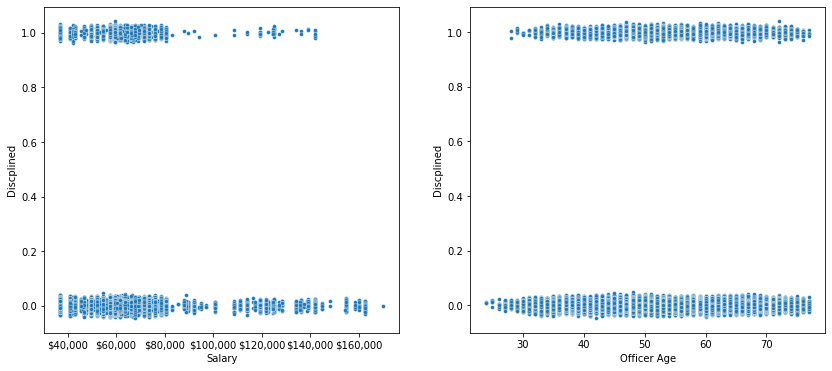

In [31]:
# Jitters points to make distribution more visible 
def jitter(values,j):
    return values + np.random.normal(j,0.01,values.shape)

# Plot response variable vs salary and officer age, see whether binning is needed
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)

ax=sns.scatterplot(df['salary'], jitter(df['disciplined'],0), s=15, edgecolors='white', linewidths=0.2)
plt.xlabel('Salary')
plt.ylabel('Discplined')
ax.xaxis.set_major_formatter('${x:,.0f}')

plt.subplot(1, 2, 2)

ax=sns.scatterplot(full_df['officer_age'], jitter(full_df['y'],0), s=15, edgecolors='white', linewidths=0.2)
plt.xlabel('Officer Age')
plt.ylabel('Discplined')

Given the non-uniform distribution of salaries between the two response values, binning salary may be appropriate.

In [32]:
# Bin salary data

def var_transform(data):
    binned_salary = pd.qcut(data['salary'],4,retbins=True)
    bins = binned_salary[1]
    data['salary_binned'] = pd.cut(data['salary'],bins = bins)
    dum = pd.get_dummies(data.salary_binned,drop_first = True)
    dum.columns = ['salary'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

salary_bin_data=var_transform(full_df)

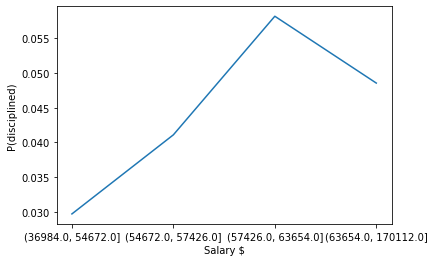

In [33]:
# Check whether probability of response changes non-monotonically across bins and whether bin number is appropriate
group_salary = salary_bin_data.groupby('salary_binned')['y'].agg([('p_disciplined','mean'),('nobs','count')]).reset_index(drop=False)

plt.plot(group_salary['salary_binned'].astype(str), group_salary['p_disciplined'])
plt.xlabel('Salary $')
plt.ylabel('P(disciplined)')
plt.show()

Binning or quadratically transforming salary appears appropriate

In [34]:
# Turn salary bins into dummy variables and concat to main dataframe 
salary_D = pd.get_dummies(full_df['salary_binned'])
temp = pd.DataFrame(columns=['salary_1', 'salary_2', 'salary_3', 'salary_4'])
temp['salary_1'] = salary_D.iloc[:,0]
temp['salary_2'] = salary_D.iloc[:,1]
temp['salary_3'] = salary_D.iloc[:,2]
temp['salary_4'] = salary_D.iloc[:,3]
# concat to data frame, drop regular salary and salary binned 
full_df = pd.concat([full_df, temp], axis=1)
full_df = full_df.drop(columns=['salary_binned', 'salary'])

In [35]:
######-----------Shuffling the dataset for K-fold------------#########

In [36]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Inference 1: What variables are most associated with whether an officer is disciplined or not? 

Strategy: Start with full model --> perform back selection, iteratively removing the predictor with the largest p-value until no more predictors have a p-value of greater than 0.05 --> check for multicollinearity with VIF

In [37]:
# All predictors 
Xs = list(full_df.columns.difference(['y']))
full_model = smf.logit('y~{}'.format('+'.join(Xs)), data = full_df).fit(maxiter=500, disp=False)
print('Percentage of 96 predictors with p-values greater than 0.05:',(full_model.pvalues[1:] > 0.05).sum() / len(Xs)*100,'%')

Percentage of 96 predictors with p-values greater than 0.05: 84.375 %


In [38]:
# Perform backward selection, removing p-values

# Start with full model 
logit_model = full_model
Xs = list(full_df.columns.difference(['y']))

while True:
    max_pvalue = max(logit_model.pvalues)
    if max_pvalue > 0.05:
        # remove the predictor with the largest p-value
        predictor_to_remove = logit_model.pvalues.idxmax()
        Xs.remove(predictor_to_remove)
        logit_model = smf.logit('y~{}'.format('+'.join(Xs)), data=full_df).fit(disp=False)
    else:
        break
        
final_back_selected_mod = logit_model
print(final_back_selected_mod.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               194142
Model:                          Logit   Df Residuals:                   194098
Method:                           MLE   Df Model:                           43
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                  0.1168
Time:                        14:15:38   Log-Likelihood:                -31133.
converged:                       True   LL-Null:                       -35251.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -3.7544      0.134    -28.119      0.000      -4.016      -3.493
ASIA_PAC_NATIV_AM                 -0.4838      0.091     -5.299      0.

In [ ]:
CHIEF                             -1.1168      0.308     -3.628      0.000      -1.720      -0.514
COMMANDER                         -0.8792 

In [60]:
final_back_selected_mod.params.sort_values().tail(5)

Operation_Personnel_Violations    1.685647
Conduct_Unbecoming__Off_duty      1.928682
Bribery___Official_Corruption     1.931911
RECRUIT_TRAINING_SECTION          2.650347
Drug___Alcohol_Abuse              3.304148
dtype: float64

In [55]:
1 - np.exp(-1.597846)

0.7976681281978599

In [57]:
1 - np.exp(-1.648782)

0.807716032077367

In [61]:
np.exp(1.685647)

5.395940977010438

In [62]:
full_df

,ADMIN_SCHOOL_SECURIT,AIRPORT_RELATED,BOMB_AND_ARSON_DIVISION,BUREAU_OF_INTERNAL_AFFAIRS,BUREAU_OF_ORGANIZED_CRIME,CENTRAL_DETENTION_UNIT,CENTRAL_INVESTIGATIONS_DIVISION,DET_DIV_ADMIN,DETACHED_SERVICES___GOVERMENT_SECURITY,DETACHED_SERVICES___MISCELLANEOUS_DETAIL,...,COMMANDER,Other_rank,PO_AS_DETECTIVE,POLICE_OFFICER,officer_age,y,salary_1,salary_2,salary_3,salary_4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,69.0,1,0,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,69.0,0,0,0,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,69.0,0,0,0,0,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,69.0,0,0,0,0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,69.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2519371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,49.0,1,1,0,0,0
2519373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,31.0,1,1,0,0,0
2519375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,29.0,1,1,0,0,0
2519380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,32.0,1,1,0,0,0


In [51]:
len(final_back_selected_mod.params)

44

The back selected model removed 53 predictors from the full model. The next thing to do is to add an additional effect size filter. We are only interested in the predictors that lead to at least a 5% change in the odds ratio of being disciplined.

In [39]:
# Get p-value back selected model's coefficients and 
p_back_selected_coefs = list(final_back_selected_mod.params[1:])
p_back_selected_params = list(final_back_selected_mod.params.index.difference(['Intercept']))
odds_ratios = np.exp(p_back_selected_coefs)
effect_sizes = abs(1 - odds_ratios)
# Find if any significant predictors were really weak (changed odds ratio by less than 10%)
weak_ind  = np.where(effect_sizes < 0.05)
print('Weak predictor to remove:', p_back_selected_params[weak_ind[0][0]])

Weak predictor to remove: officer_age


Finally, let's check that there aren't severe multicollinearity problems. By performing p-value back selection, we already likely removed many of the most multicollinear predictors, since predictors with high multicollinearity have large estimated standard errors and therefore large p-values. In fact, this was part of the motivation for back selecting in this manner.

In [40]:
def find_VIF(X): # takes matrix of predictors, calculates VIF for each
    
    X = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    for i in range(len(X.columns)):
        vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

    return vif_data.sort_values(by='VIF', ascending=False)

In [50]:
df['current_rank'].value_counts()

POLICE OFFICER     169490
PO AS DETECTIVE     21989
COMMANDER            1241
CHIEF                 761
Other                 648
UNKNOWN                13
Name: current_rank, dtype: int64

In [41]:
# Remove officer_age
#p_back_selected_params.remove('officer_age')
# Calculate VIF
vif = find_VIF(full_df[p_back_selected_params])

In [45]:
find_VIF(full_df.drop('y', axis=1))

,feature,VIF
0,const,22062.261156
91,POLICE_OFFICER,2139.120552
90,PO_AS_DETECTIVE,1944.288618
85,WHITE,841.181123
83,BLACK,671.560549
...,...,...
9,DETACHED_SERVICES___GOVERMENT_SECURITY,4.164397
93,salary_1,3.454936
92,officer_age,2.440342
86,ON,1.826083


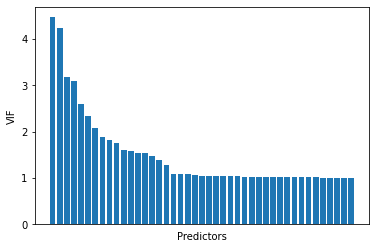

In [42]:
plt.bar(vif.iloc[1:,0], vif.iloc[1:,1])
plt.xticks([], [])
plt.xlabel('Predictors')
plt.ylabel('VIF')
plt.show()

In [43]:
print('The 3 predictors with the highest VIF are:', vif.iloc[1,0],',',vif.iloc[2,0],',',vif.iloc[3,0])

The 3 predictors with the highest VIF are: Operation_Personnel_Violations , Use_of_Force , Illegal_Search


The predictors only have moderate multicollinearity, indicating that the back selected model is stable and, crucially, that the p-values of the predictors come from precise estimates of their standard errors.

Inference 4

In [14]:
getsust = pd.read_csv('officers_only.csv')
df = pd.read_csv('cleaned_data.csv')

full_df = pd.concat([df, getsust[['sustained']]], axis=1)

sust_only = full_df.loc[full_df['sustained'] == 1]
sust_only = sust_only.drop(columns = {'sustained'})
sust_only = sust_only.drop(columns = {'Unnamed: 0'})

/var/folders/4b/sl3y8zds5g52xl7kl2dsn52w0000gn/T/ipykernel_20644/75206399.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  getsust = pd.read_csv('officers_only.csv')


In [15]:
#Dataframe showing the correlation of each columnn with the target variable
y_df = pd.DataFrame(sust_only.corr()["y"]).sort_values(by = 'y', ascending = False)


# Lasso Regression
q = list(sust_only.columns)
q.remove('y')
G = sust_only[q]

alphas = 10**np.linspace(0,-4,200)*0.5

#Define scaler
scaler = StandardScaler()
scaler.fit(G)
Gstd = scaler.transform(G)
targ = sust_only.y

lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Gstd, targ)
lassocv.alpha_

0.0029363933065947416

In [16]:
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Gstd, targ)

# create a dataframe with the coefficients from the lasso regression
coefdf = pd.concat([pd.Series(G.columns), pd.Series(lasso.coef_)],axis=1).sort_values(by = 1, ascending = True)

In [17]:
def vif(X):
    X = add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    
    for i in range(len(X.columns)):
        vif_data.loc[i, 'VIF'] = variance_inflation_factor(X.values, i)
        
    return(vif_data)

In [19]:
# use VIF to determine and remove multicollinear predictors
l = coefdf.iloc[:, 0].tolist()
lass = sust_only[l]

#drop rows with over 5 VIF
viflassdf = vif(lass)
new = viflassdf[viflassdf['VIF'] <= 5]

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.